In [1]:
#importing all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline  
sns.set(style='whitegrid',color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import random
from random import shuffle

from tqdm import tqdm
import cv2

from keras.utils import to_categorical
from keras.models import Sequential,load_model,model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop,Adadelta,Adam,Adamax,SGD
from keras import backend as K
from keras.layers import Dropout,Flatten,AveragePooling2D,MaxPooling2D,Conv2D,Activation,BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import StratifiedKFold

In [2]:
from IPython.display import Image

In [3]:
#setting path to dataset 
curr_path = os.getcwd() + '/recaptcha-dataset-main'
data_path = curr_path+'/Large'

In [4]:
def sharpen(image):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

In [5]:
def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

Bicycle


100%|███████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 459.41it/s]


Bus


100%|█████████████████████████████████████████████████████████████████████████████| 1229/1229 [00:02<00:00, 423.26it/s]


Car


100%|█████████████████████████████████████████████████████████████████████████████| 3578/3578 [00:08<00:00, 408.30it/s]


Crosswalk


100%|█████████████████████████████████████████████████████████████████████████████| 1260/1260 [00:03<00:00, 359.32it/s]


Hydrant


100%|███████████████████████████████████████████████████████████████████████████████| 972/972 [00:02<00:00, 343.39it/s]


Palm


100%|███████████████████████████████████████████████████████████████████████████████| 932/932 [00:02<00:00, 338.77it/s]


Traffic Light


100%|███████████████████████████████████████████████████████████████████████████████| 811/811 [00:02<00:00, 284.20it/s]


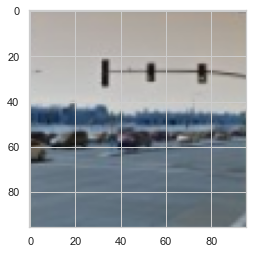

In [7]:
imglist = list()
folds = []
dr_dict = {
    'Traffic Light' : 6,'Palm':5,'Hydrant':4,'Crosswalk':3,'Car':2,'Bus':1,'Bicycle':0
}

for i in range(3):
    folds.append({"x":[],"y":[]})
for dr in os.listdir(data_path) :
    if dr not in ['Traffic Light','Palm','Hydrant','Crosswalk','Car','Bus','Bicycle'] :
        continue
    img_path = os.path.join(data_path,dr)
    print(dr)
    c = 0
    for img in tqdm(os.listdir(img_path) ):
        path = os.path.join(img_path,img)
        pic = cv2.imread(path)
        pic = cv2.resize(pic,(96,96))
        plt.imshow(pic)
        
        pic = enhance_contrast(pic)
        pic = pic/255
        folds[c%3]["x"].append(pic)
        temp = [0 for _ in range(7)]
        temp[dr_dict[dr]] = 1
        folds[c%3]["y"].append(temp)
        c+=1
        


In [8]:
def split_folds(i):
    X_train,X_test,y_train,y_test = [],0,[],0
    for j in range(3):
        if i == j:
            X_test = folds[i]["x"]
            y_test = folds[i]["y"]
        else:
            X_train += folds[i]["x"]
            y_train += folds[i]["y"]
    return np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)

In [9]:
#making cnn model
def create_new_model():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(5,5),input_shape=(96,96,3),padding='Same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=96,kernel_size=(2,2),padding='Same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(7,activation='softmax'))
    return model

In [10]:
# setting batch_size nd epooch for training the model
batch_size = 128
epooch = 50

# red_lr = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [12]:
act = []
pred = []

for i in range(3):
    X_train,X_test,y_train,y_test = split_folds(i)
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(X_train)
    model = create_new_model()
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epooch, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)
    pred+=list(model.predict(X_test))
    act+=list(y_test)
    model.save_weights(os.path.join(curr_path ,'kfold_7'+str(i)+'.h5'))

    with open(os.path.join(curr_path,'kfold_7'+str(i)+'.json'), "w") as json_file:
        json_file.write(model.to_json())
    del model
    
    tf.keras.backend.clear_session()
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    

C:\Users\MSI\AppData\Local\Temp\ipykernel_7896\2890959514.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/50
49/49 [==============================] - 42s 842ms/step - loss: 1.6594 - accuracy: 0.3777 - val_loss: 1.3614 - val_accuracy: 0.4618
Epoch 2/50
49/49 [==============================] - 45s 919ms/step - loss: 1.3288 - accuracy: 0.4842 - val_loss: 1.1444 - val_accuracy: 0.5569
Epoch 3/50
49/49 [==============================] - 50s 1s/step - loss: 1.1526 - accuracy: 0.5565 - val_loss: 1.0360 - val_accuracy: 0.6176
Epoch 4/50
49/49 [==============================] - 49s 997ms/step - loss: 1.1003 - accuracy: 0.5889 - val_loss: 1.0440 - val_accuracy: 0.6004
Epoch 5/50
49/49 [==============================] - 50s 1s/step - loss: 1.0261 - accuracy: 0.6188 - val_loss: 0.8926 - val_accuracy: 0.6668
Epoch 6/50
49/49 [==============================] - 52s 1s/step - loss: 0.9707 - accuracy: 0.6381 - val_loss: 0.8545 - val_accuracy: 0.6774
Epoch 7/50
49/49 [==============================] - 52s 1s/step - loss: 0.9384 - accuracy: 0.6458 - val_loss: 0.7670 - val_accuracy: 0.7084
Epoch 8/50


Epoch 9/50
49/49 [==============================] - 52s 1s/step - loss: 0.8598 - accuracy: 0.6808 - val_loss: 0.7152 - val_accuracy: 0.7380
Epoch 10/50
49/49 [==============================] - 52s 1s/step - loss: 0.8433 - accuracy: 0.6838 - val_loss: 0.7310 - val_accuracy: 0.7230
Epoch 11/50
49/49 [==============================] - 53s 1s/step - loss: 0.8222 - accuracy: 0.6921 - val_loss: 0.6320 - val_accuracy: 0.7640
Epoch 12/50
49/49 [==============================] - 52s 1s/step - loss: 0.7610 - accuracy: 0.7138 - val_loss: 0.6200 - val_accuracy: 0.7725
Epoch 13/50
49/49 [==============================] - 53s 1s/step - loss: 0.7512 - accuracy: 0.7215 - val_loss: 0.6213 - val_accuracy: 0.7734
Epoch 14/50
49/49 [==============================] - 53s 1s/step - loss: 0.7181 - accuracy: 0.7403 - val_loss: 0.5322 - val_accuracy: 0.8122
Epoch 15/50
49/49 [==============================] - 52s 1s/step - loss: 0.6901 - accuracy: 0.7499 - val_loss: 0.5812 - val_accuracy: 0.7922
Epoch 16/50
49

Epoch 17/50
49/49 [==============================] - 54s 1s/step - loss: 0.6897 - accuracy: 0.7445 - val_loss: 0.5608 - val_accuracy: 0.7919
Epoch 18/50
49/49 [==============================] - 54s 1s/step - loss: 0.6455 - accuracy: 0.7627 - val_loss: 0.5766 - val_accuracy: 0.7853
Epoch 19/50
49/49 [==============================] - 54s 1s/step - loss: 0.6356 - accuracy: 0.7630 - val_loss: 0.4531 - val_accuracy: 0.8389
Epoch 20/50
49/49 [==============================] - 56s 1s/step - loss: 0.5974 - accuracy: 0.7736 - val_loss: 0.4233 - val_accuracy: 0.8461
Epoch 21/50
49/49 [==============================] - 60s 1s/step - loss: 0.5916 - accuracy: 0.7864 - val_loss: 0.5191 - val_accuracy: 0.8029
Epoch 22/50
49/49 [==============================] - 56s 1s/step - loss: 0.5644 - accuracy: 0.7953 - val_loss: 0.4243 - val_accuracy: 0.8442
Epoch 23/50
49/49 [==============================] - 55s 1s/step - loss: 0.5430 - accuracy: 0.8041 - val_loss: 0.4296 - val_accuracy: 0.8421
Epoch 24/50
4

In [26]:
diff = 0
print(pred)
for i in range(len(pred)):
    max_value = max(pred[i])
    index = pred[i].index(max_value)
    max_value2 = max(act[i])
    index2 = act[i].index(max_value2)
    if index1!=index2:
        diff+=1
print(diff, len(pred))

0

In [15]:
print(act)

[array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0]), array([1,

In [21]:
pred = np.argmax(pred,axis = 0)
pred = pred.reshape(9582)
pred

ValueError: cannot reshape array of size 1 into shape (9582,)